# Setup

## Imports

In [22]:
using Logging

import QuantumToolbox as qt
using LinearAlgebra
using SparseArrays


import CairoMakie as cm

using ProtoStructs

import OrdinaryDiffEq as ODE
using OrdinaryDiffEqVerner: Vern9

import CSV
using JSON
import Tables

using YAXArrays
using DimensionalData

using MiniLoggers
using Dates
using Revise

import ProgressMeter as PM

using EllipsisNotation

In [2]:
import SuperconductingCavities as SC

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## Extra Stuff

In [3]:
Base.identify_package("OrdinaryDiffEqVerner")

OrdinaryDiffEqVerner [79d7bb75-1356-48c1-b8c0-6832512096c2]

In [4]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [5]:
function tostr(obj)
    io = IOBuffer()
    show(io, "text/plain", obj)
    String(take!(io))
end

tostr (generic function with 1 method)

# Doing Stuff

In [6]:
Mode3 = SC.Transmon_Resonators_Loader("ModelSaves/Mode_3/Mode_3.json");

In [7]:
Mode3.Stuff["op_drive_params"]["q_g_0"]

Dict{String, Any} with 6 entries:
  "pulse_time"    => 100.2
  "Envelope Args" => Dict{String, Any}("sigma"=>25.5, "mu"=>51.0)
  "epsilon"       => 0.005
  "Envelope"      => "Guassian"
  "shift"         => 0
  "freq_d"        => 4.60374

In [882]:
ψi = Mode3.dressed_states[(0,0)]

solver_kwargs = Dict{Any, Any}("abstol" => 1e-6, "reltol"=>1e-6, "alg"=> Vern9())
#res = SC.RunSingleOperator(Mode3, ψi' , Mode3.Stuff["op_drive_params"]["q_g_0"], c_ops = collect(values(Mode3.CandD_Ops)), step_name = "TEST1", save_step = true, to_return = "Last", solver_kwargs=solver_kwargs)
res = SC.RunSingleOperator(Mode3, ψi*ψi' , Mode3.Stuff["op_drive_params"]["q_g_0"], run_name = "TEST1", save_step = true, to_return = "Last", solver_kwargs=solver_kwargs)

[2024-09-18 14:26:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 03m 29s (ETA: 0h 00m 00s)
[2024-09-18 14:30:19] Info: Time Evolution Complete
[2024-09-18 14:30:19] Info: Saving Steps
[2024-09-18 14:30:25] Info: Done with DEFAULT


## Floquet Sweep For Pulse

In [123]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]
stark_shift = 0.0422143;
ε = 0.78;
T = abs(1/(stark_shift+freq_d))
t0 = stark_shift_res[2]
pulse_time = 197.702
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}(:pulse_time => pulse_time, :ramp_time=>10)

println(ε)
println(stark_shift)
times = collect(0:5*T:pulse_time)

params_list = []
for t in times
    ε_temp = ε*SC.Sine_Squared_Ramp_Envelope(t; envelope_args...)
    params = Dict{Any, Any}("ν" => freq_d+stark_shift, "ε"=>ε_temp)
    push!(params_list, params)
end


0.78
0.0422143


In [125]:
envelope_args = Dict{Any, Any}("pulse_time" => pulse_time, "ramp_time"=>10)

pulse_args = Dict{Any, Any}("pulse_time" => pulse_time, "shift" => stark_shift, "freq_d" => freq_d, "Envelope"=>envelope, "Envelope Args"=> envelope_args, "epsilon"=> ε)

run_res = SC.RunSingleOperator(Mode3, ψ1, pulse_args, to_return = "All WFs", save_step = false, tspan = times);

[2024-09-16 19:50:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-09-16 19:50:54] Info: Time Evolution Complete
[2024-09-16 19:50:54] Info: Done with DEFAULT


In [126]:
floq_sweep_res = SC.Floquet_0_Sweep(Mode3, Mode3.n̂ₜ, params_list)

[2024-09-16 19:51:04] Info: Beginning Floquet Sweep
[2024-09-16 19:52:24] Info: Done With Floquet Sweep


Dict{Any, Any} with 2 entries:
  "F_Modes"    => Any[QuantumObject{Vector{ComplexF64}, KetQuantumObject, 2}[Qu…
  "F_Energies" => Any[[-8.8335, -8.80828, 8.6949, -8.57973, -8.4845, 8.38281, -…

In [127]:
states_to_track = Dict{Any, Any}()
states_to_track["f0"] = Mode3.dressed_states[(2,0)]
states_to_track["g1"] = Mode3.dressed_states[(0,1)]
tracking_res = SC.State_Tracker(floq_sweep_res["F_Modes"], states_to_track, other_sorts = Dict{Any, Any}("F_Energies"=>floq_sweep_res["F_Energies"]));

[2024-09-16 19:52:28] Info: Tracking State f0
[2024-09-16 19:52:28] Info: Tracking State g1


In [128]:
#tracking_res[State = At("f0")]

In [130]:
y_f0_floq = []
y_g1_floq = []

for i in 1:length(times)
    push!(y_f0_floq, abs(run_res.states[i]'*tracking_res[State = At("f0")][i]["ψ"])^2)
    push!(y_g1_floq, abs(run_res.states[i]'*tracking_res[State = At("g1")][i]["ψ"])^2)
end

y_f0_floq_phase = []
y_g1_floq_phase = []

for i in 1:length(times)
    push!(y_f0_floq_phase, angle(run_res.states[i]'*tracking_res[State = At("f0")][i]["ψ"]))
    push!(y_g1_floq_phase, angle(run_res.states[i]'*tracking_res[State = At("g1")][i]["ψ"]))
end



In [131]:
println("Initial Phase Difference")
println(y_f0_floq_phase[1]-y_g1_floq_phase[1])

println("Final Phase Difference")
println(y_f0_floq_phase[end]-y_g1_floq_phase[end])


Initial Phase Difference
2.073168839961509
Final Phase Difference
2.827838726667464


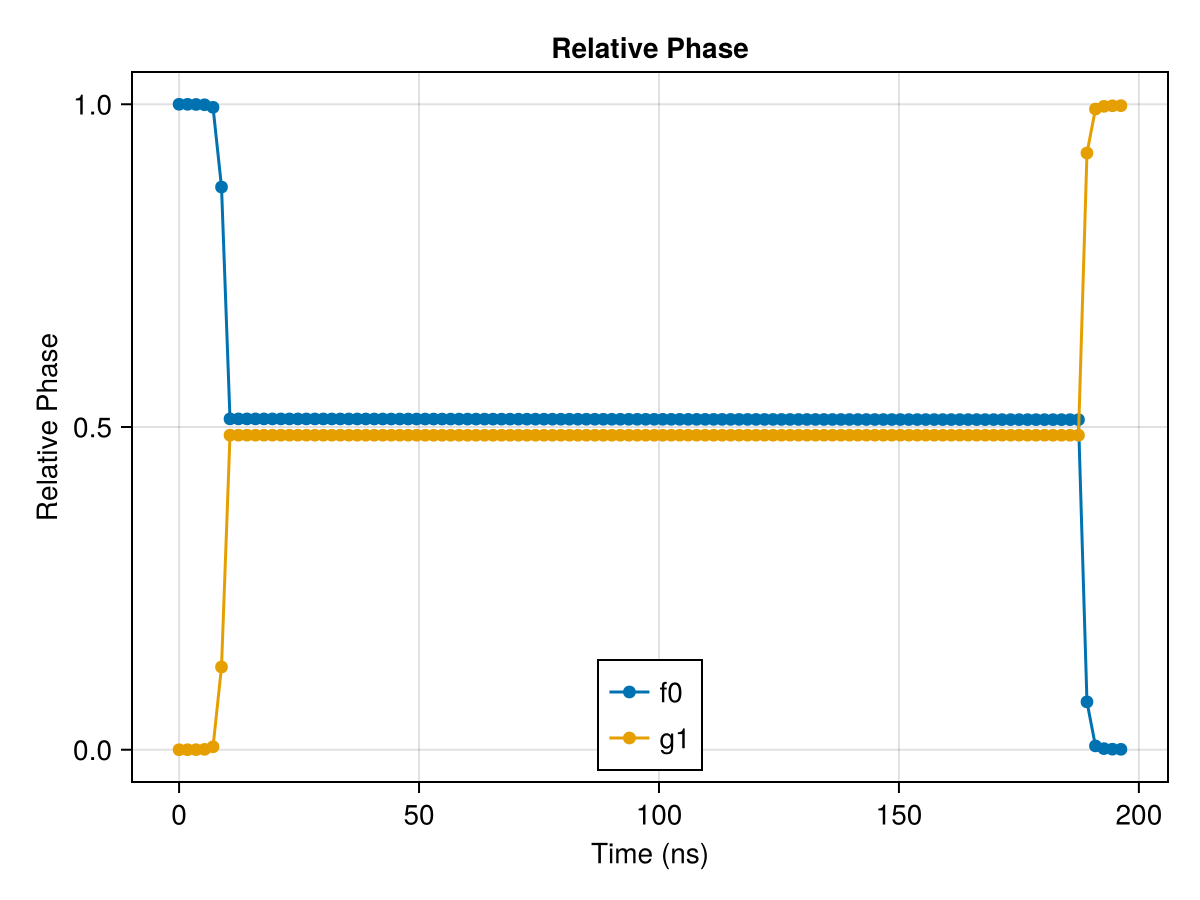

In [135]:
f = cm.Figure()
ax = cm.Axis(f[1,1], title = "Relative Phase", xlabel = "Time (ns)",  ylabel = "Relative Phase")

cm.scatterlines!(ax, times, y_f0_floq, label = "f0")
cm.scatterlines!(ax, times, y_g1_floq, label = "g1")
y =  y_f0_floq_phase-y_g1_floq_phase
for i in 1:length(y)
    if y[i]<0
        y[i] += 2 * pi
    end
end

cm.axislegend(position = :cb)

f

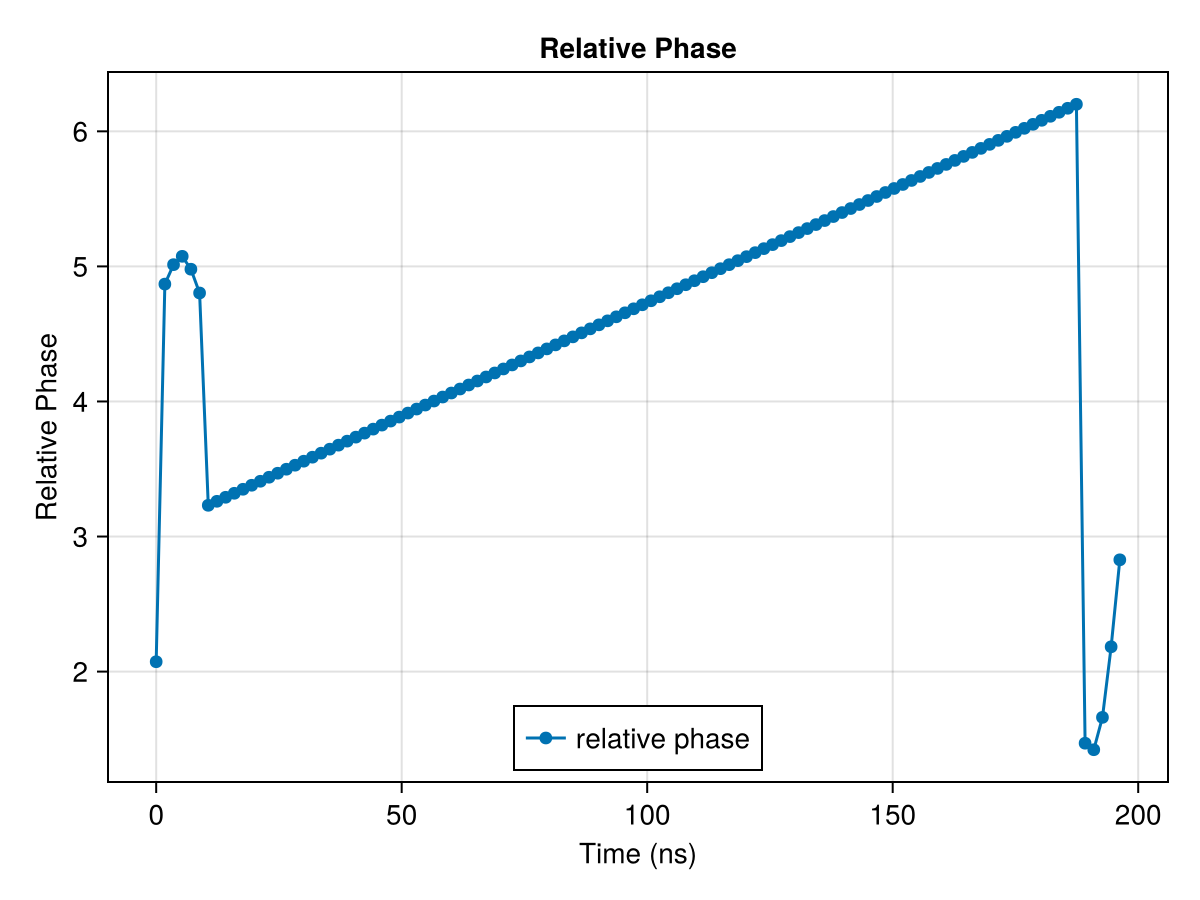

In [134]:
f = cm.Figure()
ax = cm.Axis(f[1,1], title = "Relative Phase", xlabel = "Time (ns)",  ylabel = "Relative Phase")

#cm.scatterlines!(ax, times, y_f0_floq_phase, label = "f0")
#cm.scatterlines!(ax, times, y_g1_floq_phase, label = "g1")
y =  y_f0_floq_phase-y_g1_floq_phase
for i in 1:length(y)
    if y[i]<0
        y[i] += 2 * pi
    end
end
cm.scatterlines!(ax, times, y, label = "relative phase")

cm.axislegend(position = :cb)

f

## Making Plots

In [37]:
a = rand(3,3,3);

In [49]:
selectdim(a, 1, 2)

3×3 view(::Array{Float64, 3}, 2, :, :) with eltype Float64:
 0.498791  0.424443  0.00669198
 0.830532  0.267536  0.958304
 0.736642  0.580855  0.988846

In [50]:
#dat = open_dataset("Data/Run_Loss_false_2024-09-17T14:13:35.719.nc")
dat = open_dataset("Data/Run_Loss_true_2024-09-17T14:13:35.947.nc")

InterruptException: InterruptException:

[2024-09-17 17:42:53] Info: Organizing Data
[2024-09-17 17:42:53] Info: Making Plot


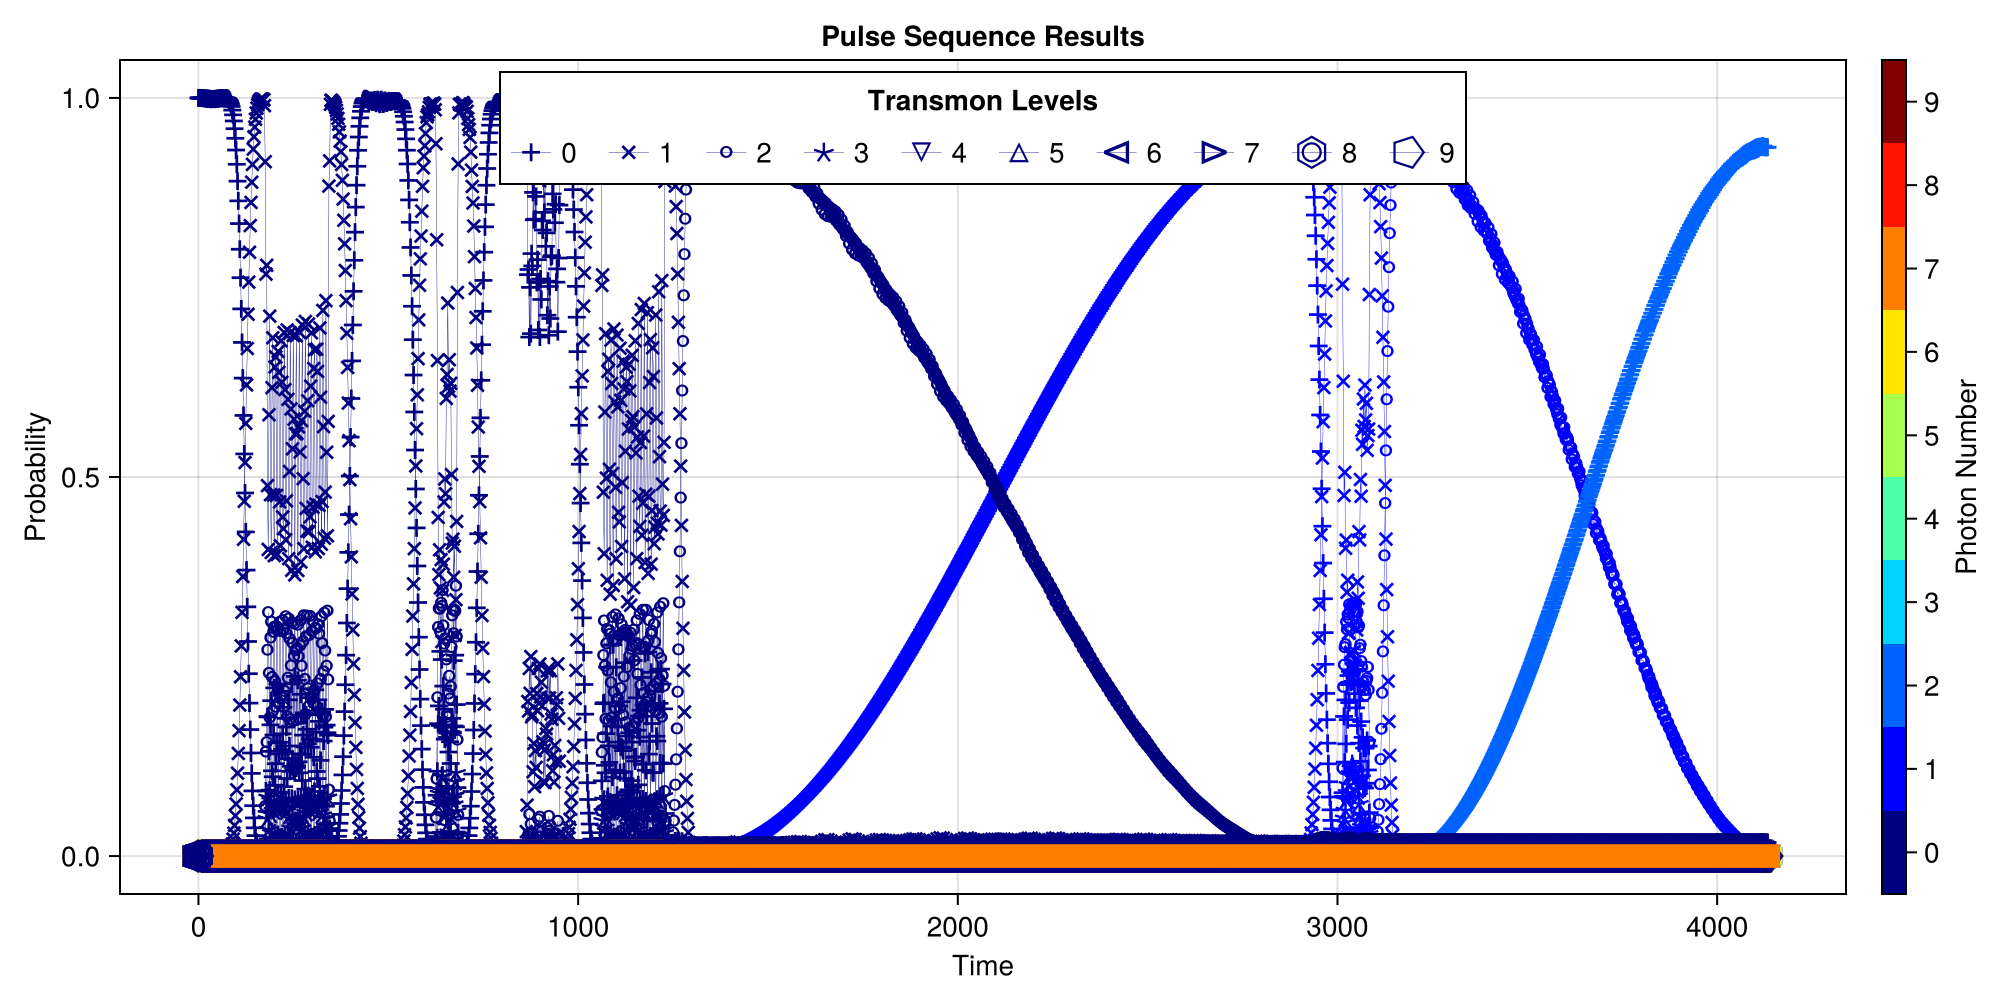

In [65]:
SC.ProbabilityPlotSingleModeEvolution(Mode3, dat, plot_every = 1)

In [61]:
norm(collect(dat.cubes[:Step_18][State = At(string((0,2))), Step_18_Steps = At(486)].data))

0.9349714801058298

# Ramsey Testing

In [113]:
ramsey = SC.LoadRunResults("Data/Ramsey_00_plus_10_2024-09-18T16:41:28.655.nc"; cube_order = ["DEFAULT"], h_dims = [10,10]);

In [114]:
ψg = Mode3.dressed_states[(0,0)];
ψe = Mode3.dressed_states[(1,0)];

In [118]:
rho = zeros(ComplexF64, length(ramsey[1]), 2, 2)
for i in 1:length(ramsey[1])
    rho[i, 1,1] = ψg'*ramsey[1][i]*ψg
    rho[i, 2,1] = ψe'*ramsey[1][i]*ψg
    rho[i, 1,2] = ψg'*ramsey[1][i]*ψe
    rho[i, 2,2] = ψe'*ramsey[1][i]*ψe
end

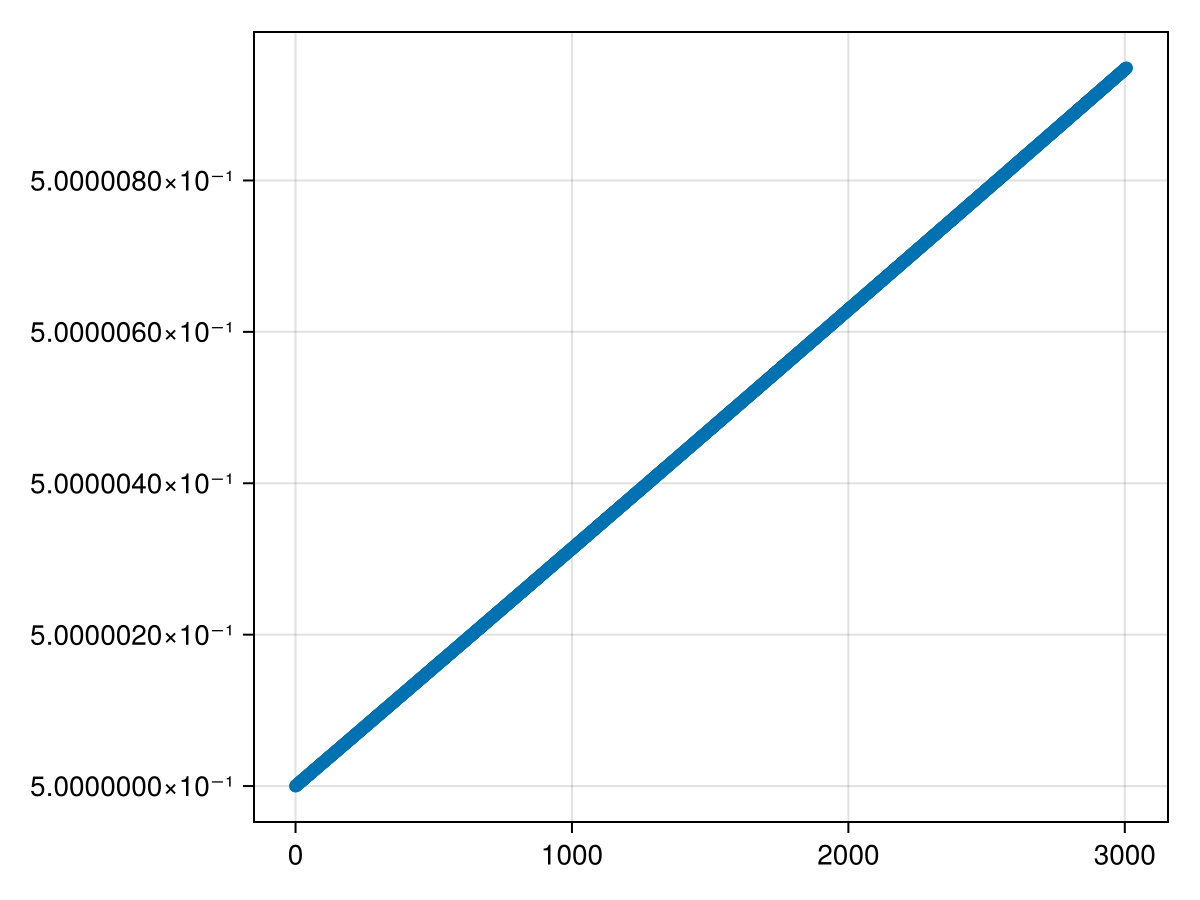

In [117]:
f = cm.Figure()
ax = cm.Axis(f[1,1])

cm.scatterlines!(ax, ramsey[2], norm.(rho[:, 1, 1]))

f

In [108]:
norm(ψe'*ramsey[1][end]*ψg)

0.49611272481743734

In [109]:
ramsey[2]

3007-element Vector{Any}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0